This code uses built-in functions from the Image class in PIL to execute isometries on a given image. It snapshots the lens view after each isometry, then puts those images into a numpy array. It then calculates the persistent homology of the data. For different images, 'lens_sz' and 'intervals' should be adjusted.

In [74]:
# Imports
import numpy as np
import math

# For image and video manipulation
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import PIL
import glob

# Persistent homology
from ripser import ripser
from persim import plot_diagrams
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
# Grab image from files
img_names = glob.glob('images/*C1bigarrows.png')
img = Image.open(img_names[0])
img = img.convert('L')

img2 = Image.open(img_names[0])
img2 = img.convert('L')
img2 = img.resize((3809*3,1614*3), resample = PIL.Image.Resampling.BOX)
#img = img.resize((540,331), resample = PIL.Image.Resampling.BOX)
#img = ImageEnhance.Sharpness(img.convert('RGB'))
#img = img.enhance(0.1)
#img = img.filter(ImageFilter.GaussianBlur(1))

# with np.printoptions(threshold=np.inf):
#     print(np.asarray(img))

#img.show()

In [66]:
# if you want to store generated images in a file
def store_snapshots(image_ls):
    counter = 0
    for img1 in image_ls:
        img1.save("images/dataset/"+str(counter)+".png")
        counter+=1

In [67]:
# see how many points are persisting
def persistingPoints(res,simpDim = 1):
    Hn = res['dgms'][simpDim].tolist() # all intervals in simpDim
    d = []
    for pair in Hn: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in Hn
    d.sort(reverse = True) # sorting from longest to shortest intervals
    print(d[:6])

translation_snapshot() translates the plane by a vector a and returns the lens view afterwards. It takes an image (Image), the lens size (int), and the translation vector (tuple) that shifts the plane in the direction of the vector. 

In [68]:
def translation_snapshot(img, lens_sz, a):
    (x,y)=a
    x=-x #since x and y will shift the crop and not the plane, need to make sure it is going in right direction
    (length, height) = img.size
    lens_corner_x=length/2.0 - lens_sz/2.0 +x
    lens_corner_y=height/2.0 - lens_sz/2.0 +y
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img

In [69]:
def fixedIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    intervals_x = np.linspace((-1)*lens_range, lens_range, translation_num)
    intervals_y = np.linspace((-1)*lens_range, lens_range, translation_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for x in intervals_x:
            for y in intervals_y:
                if lens_crunch == False:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
                else:
                        image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                          math.ceil(lens_sz / crunch_kernel)),
                                                                                         resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [70]:
def transIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = np.linspace(0, 360, degree_num)
    
    for d in degrees:
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        #print(d)
        for j in range(translation_num):
            x = rng.integers((-1)*lens_range, lens_range)
            y = rng.integers((-1)*lens_range, lens_range)
            if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
            else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))

    for j in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [71]:
def randIso(img, lens_sz, degree_num, translation_num, zero_translations, lens_crunch = False,rng_seed = 451):
    
    image_list = []
    rng = np.random.default_rng(rng_seed)
    
    lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0
    degrees = rng.uniform(0.0,360.0, size = degree_num)
    j = 0
    
    for d in degrees:
        #print(j)
        j = j + 1
        rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    for k in range(zero_translations):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
    return image_list

In [72]:
def imgListToArray(img_list):
    data = []
    x=0
    for i in image_list:
        img_arr = np.asarray(i)
        data.append(img_arr.reshape(-1))
    data = np.array(data)
    return data

[134130.0, 60690.0, 13005.0, 12750.0, 12240.0, 11985.0]


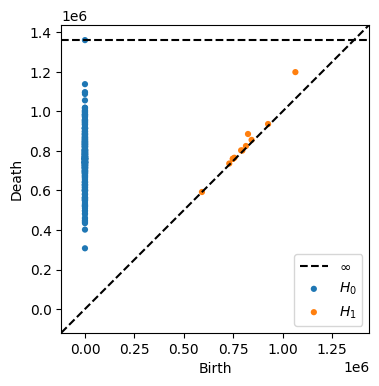

In [22]:
# make persistent homology plot with ripser
image_list = transIso(img, lens_sz = 300, degree_num = 72, translation_num = 5, zero_translations = 50)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[36975.0, 31875.0, 30855.0, 30345.0, 25755.0, 24990.0]


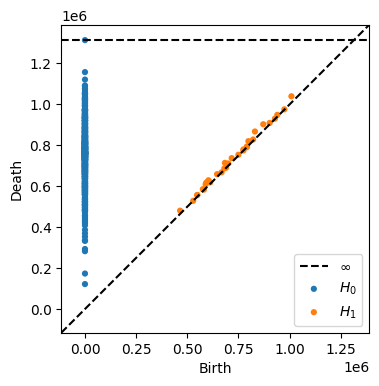

In [23]:
# make persistent homology plot with ripser
image_list = transIso(img, lens_sz = 300, degree_num = 72, translation_num = 10, zero_translations = 50)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[63750.0, 52020.0, 41565.0, 41310.0, 38505.0, 36465.0]


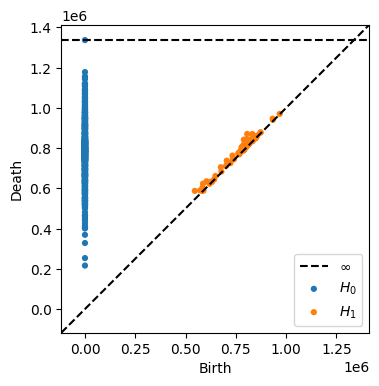

In [24]:
# make persistent homology plot with ripser
image_list = transIso(img, lens_sz = 300, degree_num = 180, translation_num = 5, zero_translations = 0)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[57885.0, 54570.0, 51000.0, 44115.0, 41310.0, 39525.0]


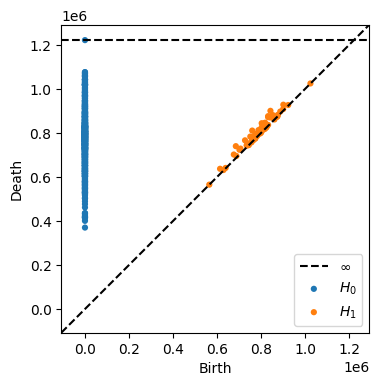

In [28]:
# make persistent homology plot with ripser
image_list = fixedIso(img, lens_sz = 300, degree_num = 90, translation_num = 3, zero_translations = 0)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[77520.0, 57885.0, 51000.0, 44115.0, 41310.0, 39525.0]


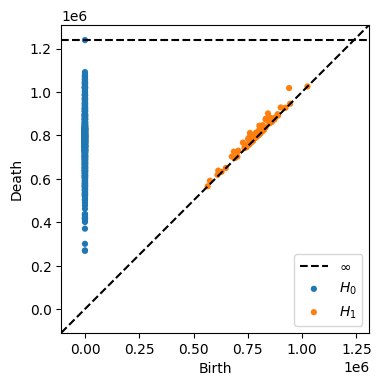

In [29]:
# make persistent homology plot with ripser
image_list = fixedIso(img, lens_sz = 300, degree_num = 90, translation_num = 3, zero_translations = 50)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[147135.0, 145350.0, 142545.0, 134640.0, 125715.0, 112200.0]


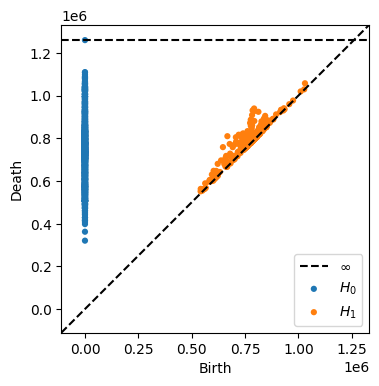

In [30]:
# make persistent homology plot with ripser
image_list = fixedIso(img, lens_sz = 300, degree_num = 180, translation_num = 3, zero_translations = 0)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[147135.0, 142545.0, 135915.0, 134640.0, 125715.0, 113985.0]


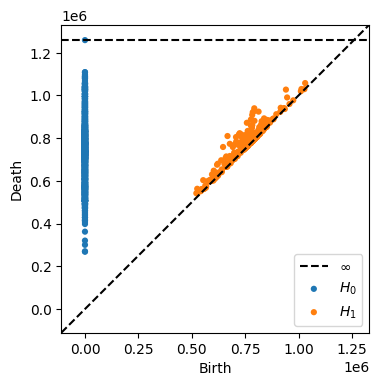

In [31]:
# make persistent homology plot with ripser
image_list = fixedIso(img, lens_sz = 300, degree_num = 180, translation_num = 3, zero_translations = 50)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[169830.0, 148410.0, 141270.0, 137955.0, 135405.0, 133620.0]


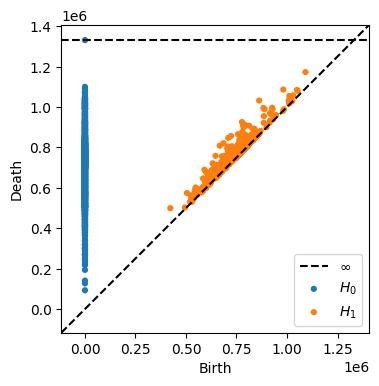

In [32]:
# make persistent homology plot with ripser
image_list = fixedIso(img, lens_sz = 300, degree_num = 180, translation_num = 3, zero_translations = 250)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[1394.765625, 1314.755859375, 1285.4013671875, 1249.7041015625, 1247.0283203125, 1201.796875]


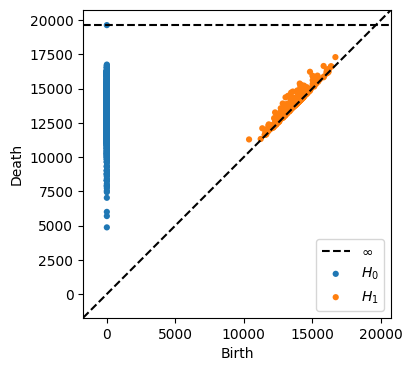

In [73]:
# make persistent homology plot with ripser
image_list = fixedIso(img, lens_sz = 300, degree_num = 180, translation_num = 3, zero_translations = 250)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "euclidean")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[164730.0, 158865.0, 149940.0, 145860.0, 145095.0, 144840.0]


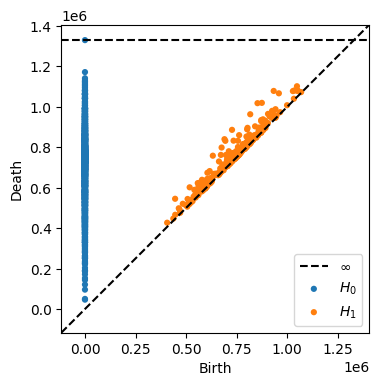

In [76]:
# make persistent homology plot with ripser
image_list = transIso(img, lens_sz = 300, degree_num = 180, translation_num = 10, zero_translations = 250)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[20910.0, 19380.0, 17085.0, 15555.0, 15300.0, 14790.0]


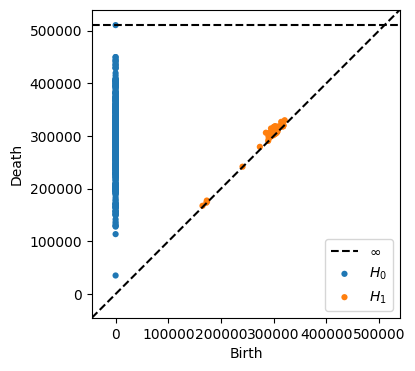

In [77]:
# make persistent homology plot with ripser
image_list = transIso(img, lens_sz = 200, degree_num = 180, translation_num = 3, zero_translations = 150)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[83130.0, 76500.0, 55335.0, 47430.0, 43860.0, 39780.0]


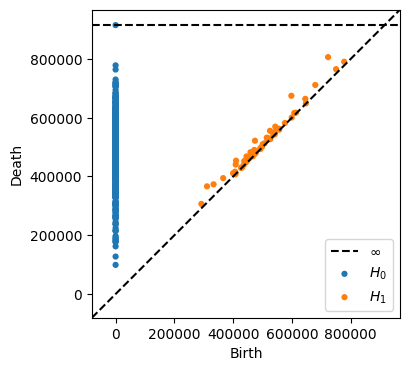

In [79]:
# make persistent homology plot with ripser
image_list = transIso(img, lens_sz = 250, degree_num = 180, translation_num = 3, zero_translations = 150)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[109650.0, 82620.0, 78540.0, 75225.0, 70890.0, 68340.0]


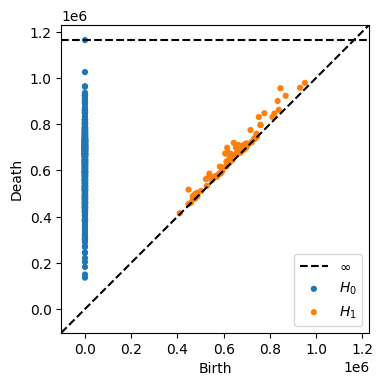

In [83]:
# make persistent homology plot with ripser
image_list = transIso(img, lens_sz = 276, degree_num = 180, translation_num = 3, zero_translations = 150)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

[558195.0, 529635.0, 517395.0, 468180.0, 341445.0, 335070.0]


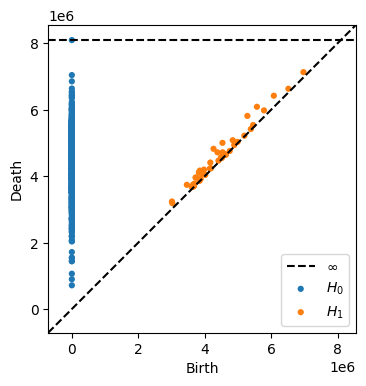

In [85]:
# make persistent homology plot with ripser
image_list = transIso(img2, lens_sz = 750, degree_num = 180, translation_num = 3, zero_translations = 150)
data = imgListToArray(image_list)
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

In [ ]:
# make persistent homology plot with ripser
image_list = transIso(img2, lens_sz = 750, degree_num = 180, translation_num = 6, zero_translations = 150)
data = imgListToArray(image_list)
print(np.shape(data))
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan", n_perm = 500)
persistingPoints(res,simpDim = 1)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

(1230, 562500)


In [86]:
store_snapshots(image_list)